# SEM EDS data interpretation

My MatSci team is working on making YBCO high temperature superconductors. To do this, we need a mixture of Yttrium, Barium and Copper powders in a 1:2:3 stoichiometric ratio. The scanning electron microscope (SEM) can tell us mass percentages of our powder at a point, but those quite a lot from one point to the next.

Assuming that the metals are normally distributed in the powder, what information can Bayesian regression tell us about the actual mean ratio of the metals?

In [6]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

from scipy.stats import poisson, norm

import pymc3 as pm

from thinkbayes2 import Suite,Joint,Pmf
import thinkplot

In [7]:
#our observed values for Ba, Cu, Y and the error bars the SEM gave us.
#the error bars are unused

data=np.array([[42.7, 40.4, 16.8, 0.3, 0.3, 0.3], 
      [45.0, 42.6, 12.5, 0.3, 0.4, 0.3], 
      [73.2, 13.8, 13.1, 0.4, 0.3, 0.3], 
      [62.2, 27.0, 10.8, 0.3, 0.3, 0.3], 
      [54.2, 35.7, 10.2, 0.4, 0.4, 0.3], 
      [58.5, 33.9, 7.6, 0.4,0.4, 0.4], 
      [62.3, 33.7, 4.0, 0.3, 0.3, 0.3]]);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigmaCu, sigmaBa, muCu, muBa]
Sampling 10 chains: 100%|██████████| 40000/40000 [00:13<00:00, 2986.52draws/s]
/home/hrachootin/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


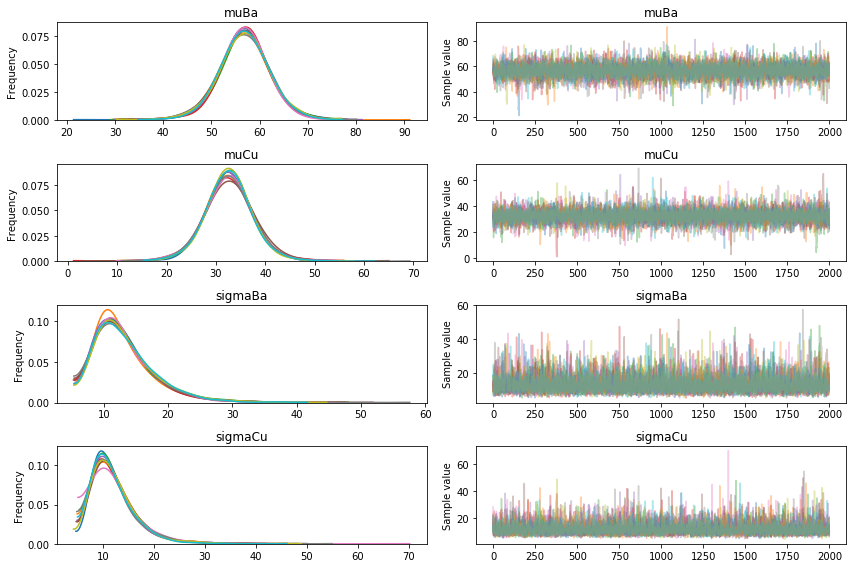

In [8]:
Ba = data[:,0];
Cu = data[:,1];
Y  = data[:,2];

#these are unused
tauBa = data[:,3];
tauCu = data[:,4];
tauY  = data[:,5];



model = pm.Model()


with model:
    muBa = pm.Normal("muBa",mu=49.558835,sd=40);
    muCu = pm.Normal("muCu",mu=34.398906,sd=40);
    
    #since our data always add up to 100%, we really only have two degrees of freedom.
    #the yttrium has the lowest mean, so its relative error is the highest, so we
    #remove its data
    
    #muY  = pm.Uniform("muY" ,lower=0,upper=100);
    sigmaBa = pm.HalfNormal("sigmaBa",sd=30);
    sigmaCu = pm.HalfNormal("sigmaCu",sd=30);
    #sigmaY  = pm.HalfNormal("sigmaY",sd=30);
    
    percentBa = pm.Normal("pBa",mu=muBa,sd=sigmaBa,observed=Ba)
    percentCu = pm.Normal("pCu",mu=muCu,sd=sigmaCu,observed=Cu)
    #percentY = pm.Normal("pY",mu=muBa,sd=sigmaY,observed=Y)
    
    trace = pm.sample(2000, tune=2000,chains=10,cores=10)
    
pm.traceplot(trace);

In [9]:
map_estimate = pm.find_MAP(model=model)

map_estimate

logp = -67.828, ||grad|| = 0.17983: 100%|██████████| 21/21 [00:00<00:00, 905.08it/s]  


{'muBa': array(56.80983371),
 'muCu': array(32.45651363),
 'sigmaBa_log__': array(2.27769205),
 'sigmaCu_log__': array(2.18299607),
 'sigmaBa': array(9.75414234),
 'sigmaCu': array(8.87285017)}

In [17]:
mBa = 137.327;
mCu = 63.546;
mY  = 88.90585;

#this are the numbers we hope for, in a 1:2:3 ratio
expect = np.array([2*mBa,3*mCu,mY])/sum([mY,2*mBa,3*mCu])

print(expect*100)

[49.55883535 34.39890646 16.04225819]


In [15]:
print(np.mean(trace["muBa"]))
print(np.mean(trace["muCu"]))
print(np.array(100-np.mean(trace["muBa"])-np.mean(trace["muCu"])))

56.68001666024308
32.53828136218159
10.781701977575324


Now, to figure out our chances of success, we want the probability that each of our elements are within any interval of their correct values. It's like a continuous p-value.

In [109]:
pBaWithin=[np.count_nonzero(abs(trace["muBa"]-expect[0]*100)<x)/len(trace["muBa"]) for x in range(100)];

pCuWithin=[np.count_nonzero(abs(trace["muCu"]-expect[1]*100)<x)/len(trace["muBa"]) for x in range(100)];

pYWithin=[np.count_nonzero(abs(100-trace["muCu"]-trace["muBa"]-expect[2]*100)<x)/len(trace["muBa"]) for x in range(100)];

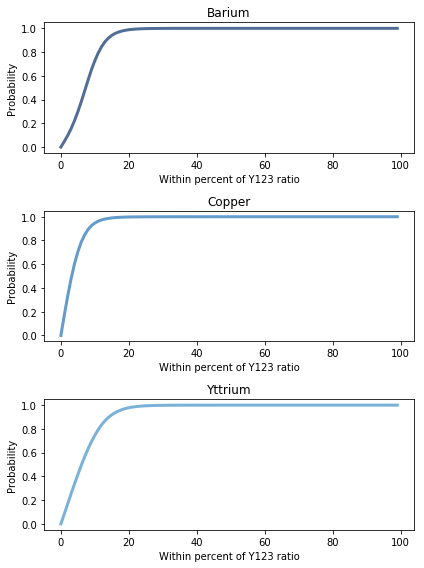

In [110]:
thinkplot.figure()
thinkplot.subplot(1,rows=3,cols=1)
thinkplot.Plot(pBaWithin)
thinkplot.decorate(
    title='Barium',
    xlabel='Within percent of Y123 ratio',
    ylabel='Probability'
    )
thinkplot.subplot(2,rows=3,cols=1)
thinkplot.Plot(pCuWithin)
thinkplot.decorate(
    title='Copper',
    xlabel='Within percent of Y123 ratio',
    ylabel='Probability'
    )
thinkplot.subplot(3,rows=3,cols=1)
thinkplot.Plot(pYWithin)
thinkplot.decorate(
    title='Yttrium',
    xlabel='Within percent of Y123 ratio',
    ylabel='Probability'
    )

So it looks like each element is within 20% of expectation. That is probably not good enough. We went ahead and attempted the reaction to make YBCO, and it did not work. Oh well.